In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import unicodedata
import re



### Merge the Catalogue and Borrow


In [177]:
# ============================================================================
# PART 1: CHECK MATCH BETWEEN CATALOGUE AND BORROWINGS
# ============================================================================

BORROWINGS =pd.read_excel("../Clean_Data/cleaned_borrowings.xlsx")
LIBRARY_CATALOGUE = pd.read_excel("../Clean_Data/cleaned_catalogue.xlsx")


# Get unique titles
borrowing_titles = set(BORROWINGS['Titre_clean'].unique())
catalogue_titles = set(LIBRARY_CATALOGUE['Titre_clean'].unique())

# Find matches
matching_titles = borrowing_titles & catalogue_titles
missing_titles = borrowing_titles - catalogue_titles
# ============================================================================
# PART 2: AGGREGATE BORROWINGS AND MERGE WITH LIBRARY_CATALOGUE
# ============================================================================

def normalize_text(text):
    text = str(text).strip().upper()
    text = unicodedata.normalize('NFKD', text)
    text = ''.join(c for c in text if not unicodedata.combining(c))
    return text



# Map borrower categories
BORROWINGS['Catégorie_norm'] = BORROWINGS['Catégorie'].apply(normalize_text)
category_map = {
    '1 ERE ANNEE': '1y', '2 EME ANNEE': '2y', '3 EME ANNEE': '3y',
    '4 EME ANNEE': '4y', '5 EME ANNEE': '5y', 'ENSEIGNANT': 'teacher'
}
BORROWINGS['borrower_group'] = BORROWINGS['Catégorie_norm'].map(category_map)
BORROWINGS = BORROWINGS[BORROWINGS['borrower_group'].notna()]

# Process semester
BORROWINGS['borrowing duration'] = pd.to_numeric(BORROWINGS['borrowing duration'], errors='coerce')
median_duration = BORROWINGS['borrowing duration'].median()
BORROWINGS['borrowing duration'] = BORROWINGS['borrowing duration'].fillna(median_duration)
BORROWINGS['Semester'] = BORROWINGS['borrowing duration'].apply(lambda x: 1 if x <= median_duration else 2)

# Add missing books to LIBRARY_CATALOGUE
missing_books = []
for title in missing_titles:
    sample = BORROWINGS[BORROWINGS['Titre_clean'] == title].iloc[0]
    missing_books.append({
        'Titre': sample['Titre'],
        'Titre_clean': title,
        'Cote': sample['Cote'] if 'Cote' in sample else f"MISSING_{len(missing_books)}",
        'Source': 'Added from borrowings'
    })

if len(missing_books) > 0:
    missing_df = pd.DataFrame(missing_books)
    LIBRARY_CATALOGUE = pd.concat([LIBRARY_CATALOGUE, missing_df], ignore_index=True)


# Aggregate by borrower type
borrow_agg = BORROWINGS.groupby(['Titre_clean', 'borrower_group']).size().unstack(fill_value=0)
borrower_columns = ['1y', '2y', '3y', '4y', '5y', 'teacher']
for col in borrower_columns:
    if col not in borrow_agg.columns:
        borrow_agg[col] = 0
borrow_agg = borrow_agg.reset_index()[['Titre_clean'] + borrower_columns]

# Aggregate by semester
semester_agg = BORROWINGS.groupby(['Titre_clean', 'Semester']).size().unstack(fill_value=0)
for sem in [1, 2]:
    if sem not in semester_agg.columns:
        semester_agg[sem] = 0
semester_agg = semester_agg.rename(columns={1: 'semester_1', 2: 'semester_2'}).reset_index()

# Merge aggregations
borrowing_features = borrow_agg.merge(semester_agg, on='Titre_clean', how='left')

# Merge with LIBRARY_CATALOGUE
full_library_dataset = LIBRARY_CATALOGUE.merge(borrowing_features, on='Titre_clean', how='left')

# Fill missing values
final_columns = borrower_columns + ['semester_1', 'semester_2']
full_library_dataset[final_columns] = full_library_dataset[final_columns].fillna(0)
full_library_dataset['total_borrowed'] = full_library_dataset[borrower_columns].sum(axis=1)


**_Extract all existing ISBN group digits_**


In [178]:


# ============================================================================
# 1. COTE-BASED FEATURES (Dewey Decimal Classification)
# ============================================================================

def extract_cote_digits(cote):
    if pd.isna(cote):
        return None
    match = re.search(r'(\d+)', str(cote))
    return match.group(1) if match else None

full_library_dataset['cote_digits'] = full_library_dataset['Cote'].apply(extract_cote_digits)

dewey_to_topic_fr = {
    '000': 'Informatique et information', '004': 'Traitement des données, informatique',
    '005': 'Programmation informatique', '006': 'Méthodes informatiques spéciales',
    '100': 'Philosophie et psychologie', '200': 'Religion', '300': 'Sciences sociales',
    '400': 'Langues', '500': 'Sciences naturelles et mathématiques',
    '510': 'Mathématiques', '511': 'Mathématiques générales', '512': 'Algèbre',
    '513': 'Arithmétique', '514': 'Topologie', '515': 'Analyse mathématique',
    '516': 'Géométrie', '517': 'Calcul', '518': 'Analyse numérique',
    '519': 'Probabilités et mathématiques appliquées', '520': 'Astronomie',
    '530': 'Physique', '540': 'Chimie', '550': 'Sciences de la terre',
    '560': 'Paléontologie', '570': 'Sciences de la vie, biologie',
    '580': 'Botanique', '590': 'Zoologie', '600': 'Technologie (sciences appliquées)',
    '610': 'Médecine et santé', '620': 'Ingénierie', '621': 'Physique appliquée',
    '629': 'Autres branches de l\'ingénierie', '630': 'Agriculture',
    '640': 'Économie domestique', '650': 'Gestion et services auxiliaires',
    '660': 'Génie chimique', '670': 'Fabrication',
    '680': 'Fabrication pour usages spécifiques', '690': 'Construction',
    '700': 'Arts et loisirs', '800': 'Littérature', '900': 'Histoire et géographie'
}

def map_cote_to_topic(cote_digits):
    if pd.isna(cote_digits):
        return 'Non classé'
    cote_str = str(cote_digits)
    if cote_str in dewey_to_topic_fr:
        return dewey_to_topic_fr[cote_str]
    if len(cote_str) >= 2:
        key_2 = cote_str[:2] + '0'
        if key_2 in dewey_to_topic_fr:
            return dewey_to_topic_fr[key_2]
    if len(cote_str) >= 1:
        key_1 = cote_str[0] + '00'
        if key_1 in dewey_to_topic_fr:
            return dewey_to_topic_fr[key_1]
    return 'Autre'

full_library_dataset['topic_fr'] = full_library_dataset['cote_digits'].apply(map_cote_to_topic)

# ============================================================================
# 2. ISBN-BASED FEATURES
# ============================================================================

def clean_isbn(isbn_raw):
    if pd.isna(isbn_raw):
        return None
    isbn_str = str(isbn_raw).strip().replace('-', '').replace(' ', '')
    isbn_str = re.sub(r'^(ISBN|isbn|ISSN|issn)[:\s-]*', '', isbn_str)
    isbn_clean = re.sub(r'\D', '', isbn_str)
    if len(isbn_clean) == 10 or len(isbn_clean) == 13:
        return isbn_clean
    if len(isbn_clean) >= 9:
        return isbn_clean
    return None

full_library_dataset['isbn_clean'] = full_library_dataset['ISBN, ISSN...'].apply(clean_isbn)

def extract_isbn_group_digit(isbn_clean):
    if pd.isna(isbn_clean) or isbn_clean is None:
        return None
    isbn_str = str(isbn_clean)
    if len(isbn_str) == 13 and isbn_str.startswith(('978', '979')):
        return isbn_str[3]
    if len(isbn_str) >= 1:
        return isbn_str[0]
    return None

full_library_dataset['isbn_group_digit'] = full_library_dataset['isbn_clean'].apply(extract_isbn_group_digit)

isbn_country_mapping_fr = {
    '0': 'Pays anglophones', '1': 'Pays anglophones', '2': 'Pays francophones',
    '3': 'Pays germanophones', '4': 'Pays asiatiques', '5': 'Pays slaves/Russie',
    '7': 'Pays scandinaves / autres', '8': 'Autre région', '9': 'Autre région'
}

full_library_dataset['isbn_country_fr'] = full_library_dataset.apply(
    lambda row: isbn_country_mapping_fr.get(str(row['isbn_group_digit']), 'Autre région') 
    if row['isbn_clean'] is not None else 'Sans ISBN', axis=1
)

# ============================================================================
# 3. TEXT-BASED FEATURES
# ============================================================================

full_library_dataset['title_length'] = full_library_dataset['Titre_clean'].apply(
    lambda x: len(str(x)) if pd.notna(x) else 0
)
full_library_dataset['title_word_count'] = full_library_dataset['Titre_clean'].apply(
    lambda x: len(str(x).split()) if pd.notna(x) else 0
)
full_library_dataset['has_author'] = full_library_dataset['Auteur'].notna().astype(int)

if 'Nbr. Exp.' in full_library_dataset.columns:
    full_library_dataset['num_copies'] = pd.to_numeric(
        full_library_dataset['Nbr. Exp.'], errors='coerce'
    ).fillna(1)

# ============================================================================
# 4. BORROWING PATTERN FEATURES
# ============================================================================

borrowing_features = ['1y', '2y', '3y', '4y', '5y', 'teacher', 
                      'semester_1', 'semester_2', 'total_borrowed']
available_features = [f for f in borrowing_features if f in full_library_dataset.columns]

# ============================================================================
# 5. DERIVED/COMPUTED FEATURES
# ============================================================================

if 'num_copies' in full_library_dataset.columns and 'total_borrowed' in full_library_dataset.columns:
    full_library_dataset['borrow_per_copy'] = (
        full_library_dataset['total_borrowed'] / full_library_dataset['num_copies']
    )

if 'total_borrowed' in full_library_dataset.columns:
    threshold = full_library_dataset['total_borrowed'].quantile(0.75)
    full_library_dataset['is_popular'] = (
        full_library_dataset['total_borrowed'] >= threshold
    ).astype(int)

year_columns = ['1y', '2y', '3y', '4y', '5y']
if all(col in full_library_dataset.columns for col in year_columns):
    full_library_dataset['primary_audience'] = full_library_dataset[year_columns].idxmax(axis=1)

if all(col in full_library_dataset.columns for col in ['semester_1', 'semester_2']):
    full_library_dataset['semester_preference'] = full_library_dataset.apply(
        lambda row: 'Semester 1' if row['semester_1'] > row['semester_2'] 
                    else ('Semester 2' if row['semester_2'] > row['semester_1'] 
                    else 'Equal'), axis=1
    )

# ============================================================================
# SAVE THE ENGINEERED DATASET
# ============================================================================

output_path = "../data/Final_data_for_clustering.xlsx"
full_library_dataset.to_excel(output_path, index=False)


###  Bar chart showing total borrowings by reader category ###

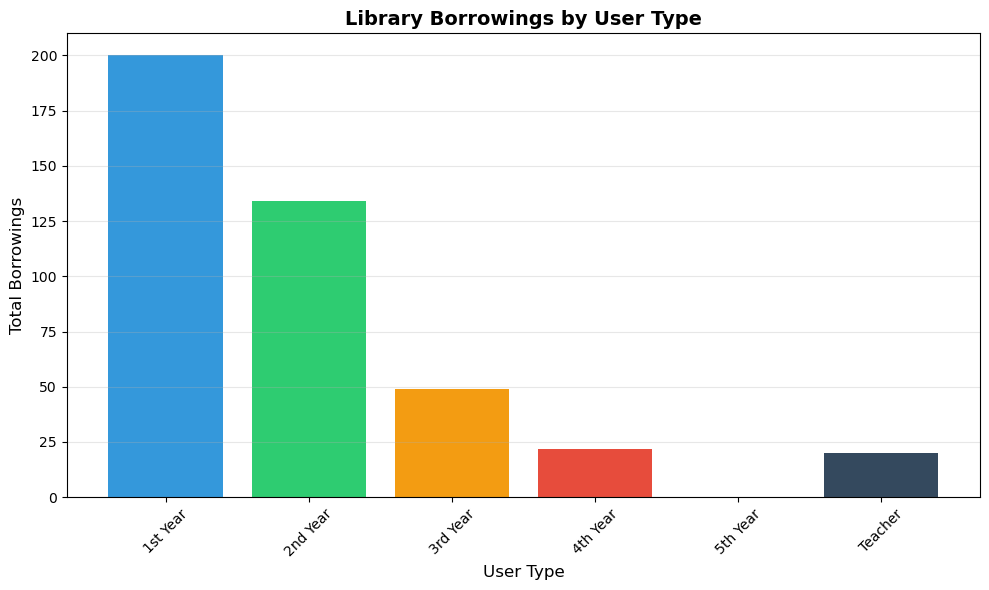

In [179]:

df=pd.read_excel("../data/Final_data_for_clustering.xlsx")
# Sum borrowings by user type
borrowing_by_type = {
    '1st Year': df['1y'].sum(),
    '2nd Year': df['2y'].sum(),
    '3rd Year': df['3y'].sum(),
    '4th Year': df['4y'].sum(),
    '5th Year': df['5y'].sum(),
    'Teacher': df['teacher'].sum()
}

# Create DataFrame for plotting
plot_data = pd.DataFrame(list(borrowing_by_type.items()), 
                         columns=['User Type', 'Total Borrowings'])

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(plot_data['User Type'], plot_data['Total Borrowings'], 
        color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6', '#34495e'])
plt.xlabel('User Type', fontsize=12)
plt.ylabel('Total Borrowings', fontsize=12)
plt.title('Library Borrowings by User Type', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



#### Borrower Categories Across Topics ####

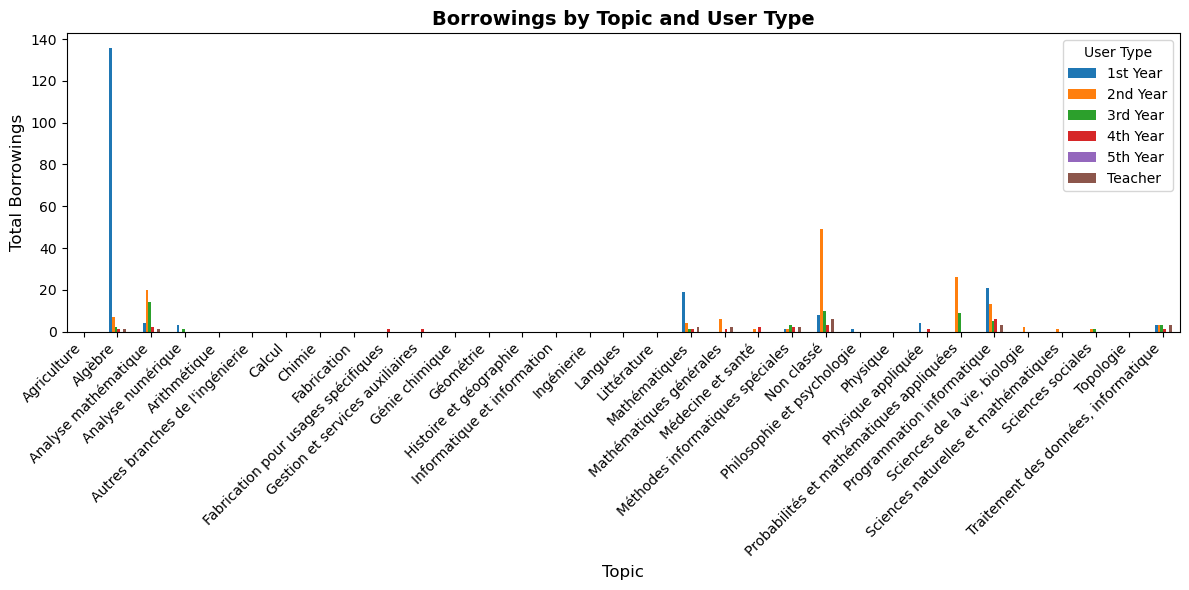

In [180]:

topic_year_data = df.groupby('topic_fr')[['1y', '2y', '3y', '4y', '5y', 'teacher']].sum()

# Bar chart - stacked or grouped
topic_year_data.plot(kind='bar', figsize=(12, 6), stacked=False)
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Total Borrowings', fontsize=12)
plt.title('Borrowings by Topic and User Type', fontsize=14, fontweight='bold')
plt.legend(title='User Type', labels=['1st Year', '2nd Year', '3rd Year', '4th Year', '5th Year', 'Teacher'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Semester vs Topic ####

<Figure size 1000x600 with 0 Axes>

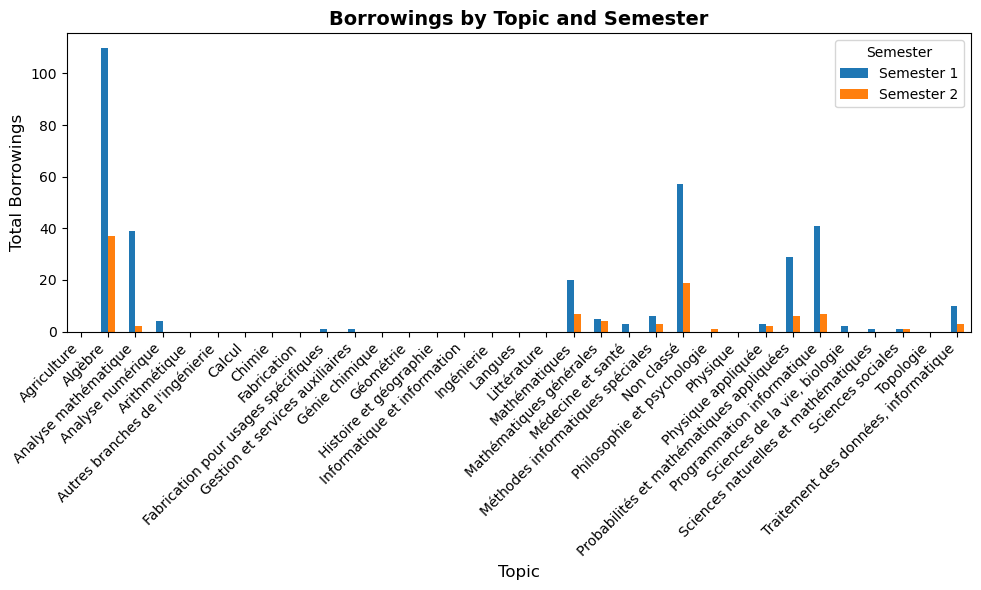

In [181]:

semester_topic = df.groupby('topic_fr')[['semester_1', 'semester_2']].sum()

plt.figure(figsize=(10, 6))
semester_topic.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Total Borrowings', fontsize=12)
plt.title('Borrowings by Topic and Semester', fontsize=14, fontweight='bold')
plt.legend(title='Semester', labels=['Semester 1', 'Semester 2'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



## Book Ctegory

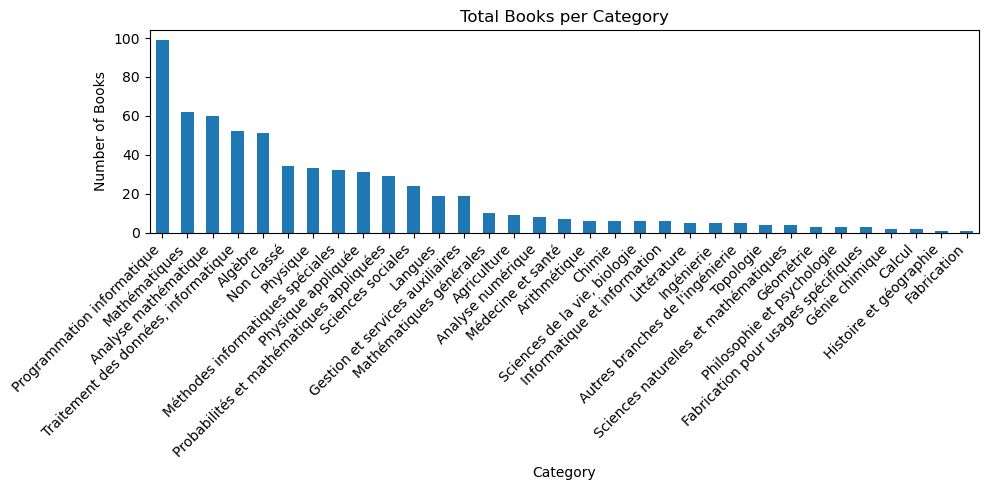

In [182]:
category_counts = df["topic_fr"].value_counts()
category_counts.plot(kind="bar", figsize=(10,5))
plt.title("Total Books per Category")
plt.xlabel("Category")
plt.ylabel("Number of Books")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

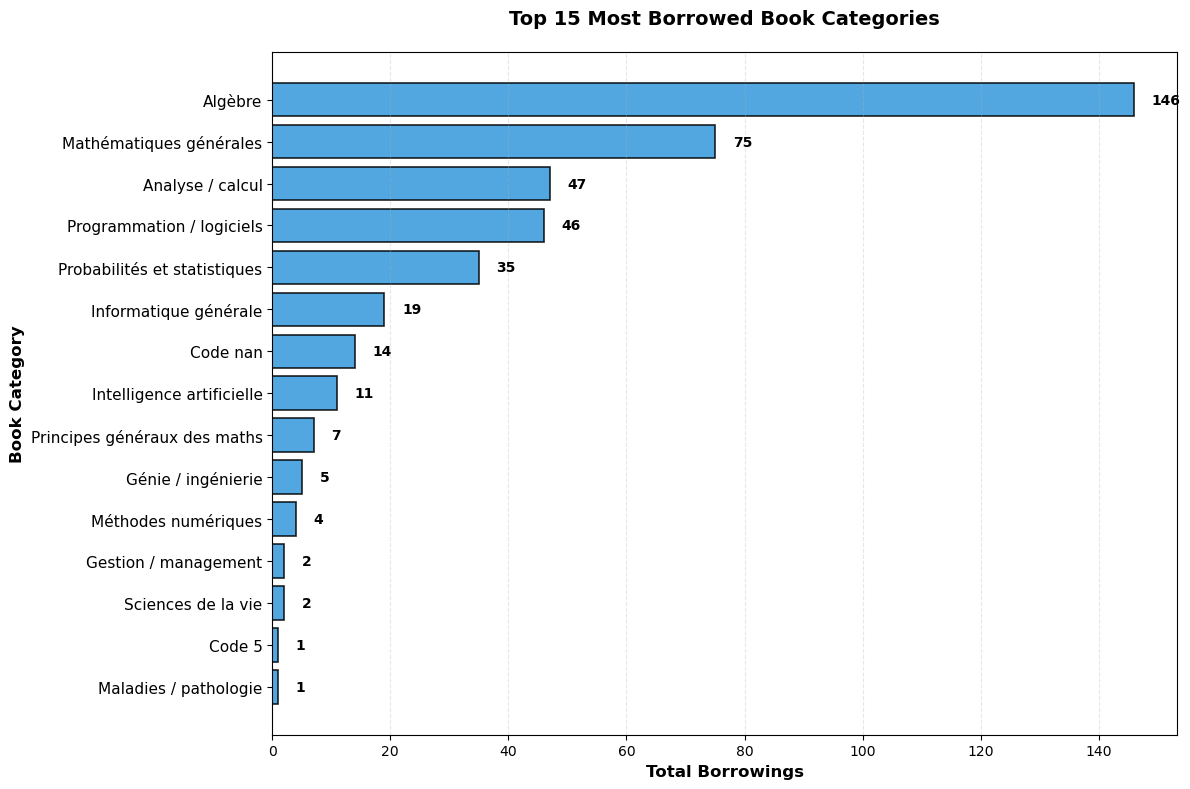

Top 10 Most Borrowed Categories:
 1. Algèbre                                  :   146 (34.60%)
 2. Mathématiques générales                  :    75 (17.77%)
 3. Analyse / calcul                         :    47 (11.14%)
 4. Programmation / logiciels                :    46 (10.90%)
 5. Probabilités et statistiques             :    35 ( 8.29%)
 6. Informatique générale                    :    19 ( 4.50%)
 7. Code nan                                 :    14 ( 3.32%)
 8. Intelligence artificielle                :    11 ( 2.61%)
 9. Principes généraux des maths             :     7 ( 1.66%)
10. Génie / ingénierie                       :     5 ( 1.18%)


In [ ]:

# Category mapping
CATEGORY_MAPPING = {
    '004': "Informatique générale",
    '005': "Programmation / logiciels",
    '006': "Intelligence artificielle",
    '150': "Psychologie",
    '230': "Christianisme / religion",
    '350': "Administration publique",
    '380': "Commerce / communication",
    '510': "Mathématiques générales",
    '511': "Principes généraux des maths",
    '512': "Algèbre",
    '515': "Analyse / calcul",
    '518': "Méthodes numériques",
    '519': "Probabilités et statistiques",
    '570': "Sciences de la vie",
    '610': "Médecine / santé",
    '611': "Anatomie",
    '616': "Maladies / pathologie",
    '621': "Génie / ingénierie",
    '658': "Gestion / management",
    '681': "Informatique appliquée",
    '808': "Techniques d'écriture"
}

# Extract category code (first 3 digits from cote)
BORROWINGS['category_code'] = BORROWINGS['Cote'].astype(str).str[:3]

# Count borrowings by category
borrowings_by_category = BORROWINGS['category_code'].value_counts()

# Map to human-readable names
borrowings_by_category.index = borrowings_by_category.index.map(
    lambda x: CATEGORY_MAPPING.get(x, f"Code {x}")
)

# Create horizontal bar chart
plt.figure(figsize=(12, 8))
top_15 = borrowings_by_category.head(15)

plt.barh(range(len(top_15)), top_15.values, color='#3498db', alpha=0.85, edgecolor='black', linewidth=1.2)
plt.yticks(range(len(top_15)), top_15.index, fontsize=11)
plt.xlabel('Total Borrowings', fontsize=12, fontweight='bold')
plt.ylabel('Book Category', fontsize=12, fontweight='bold')
plt.title('Top 15 Most Borrowed Book Categories', fontsize=14, fontweight='bold', pad=20)

# Add value labels
for i, v in enumerate(top_15.values):
    plt.text(v + 3, i, str(v), va='center', fontsize=10, fontweight='bold')

plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.gca().invert_yaxis()  # #1 at the top
plt.tight_layout()
plt.show()

# Print summary
print("Top 10 Most Borrowed Categories:")
for i, (cat, count) in enumerate(borrowings_by_category.head(10).items(), 1):
    pct = (count / len(BORROWINGS)) * 100
    print(f"{i:2d}. {cat:40s} : {count:5d} ({pct:5.2f}%)")

# Borrowing Analysis

In [ ]:
# Group by user to create transactions
Borrowings_transactions = BORROWINGS.groupby("N° lecteur")["Titre_clean"].apply(list).reset_index()

# Calculate number of books per user
Borrowings_transactions['num_books_borrowed'] = Borrowings_transactions['Titre_clean'].apply(len)

print(f"Total Users: {len(Borrowings_transactions)}")
print(f"Total Borrowings: {len(BORROWINGS)}")
print(f"Average Books per User: {Borrowings_transactions['num_books_borrowed'].mean():.2f}")

Total Users: 269
Total Borrowings: 420
Average Books per User: 1.56


**Categorize users by borrowing behavior**

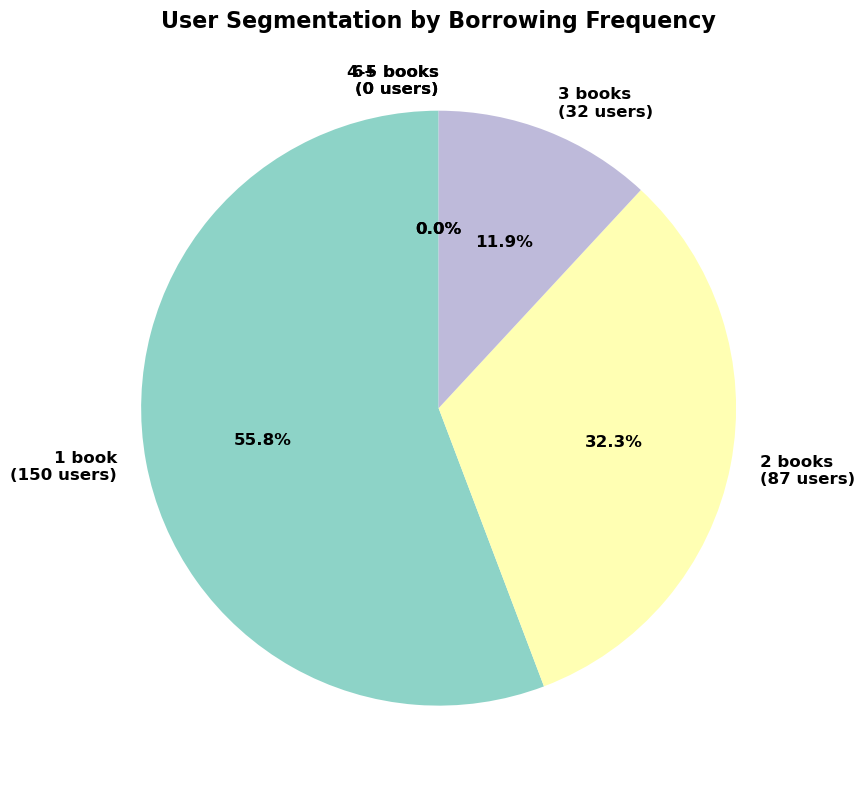

In [ ]:
plt.figure(figsize=(10, 8))

# Create borrowing categories
borrowing_categories = pd.cut(Borrowings_transactions['num_books_borrowed'],
                              bins=[0, 1, 2, 3, 5, float('inf')],
                              labels=['1 book', '2 books', '3 books', '4-5 books', '6+ books'])

category_counts = borrowing_categories.value_counts().sort_index()

# Create pie chart
colors = plt.cm.Set3(range(len(category_counts)))
wedges, texts, autotexts = plt.pie(category_counts, 
                                     labels=category_counts.index,
                                     autopct='%1.1f%%',
                                     startangle=90,
                                     colors=colors,
                                     textprops={'fontsize': 12, 'fontweight': 'bold'})

# Add counts to labels
for i, (label, count) in enumerate(zip(category_counts.index, category_counts.values)):
    texts[i].set_text(f'{label}\n({count} users)')

plt.title('User Segmentation by Borrowing Frequency', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('user_segmentation.png', dpi=300, bbox_inches='tight')
plt.show()